In [1]:
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv1D, Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from itertools import groupby
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


In [2]:
kaggle_environment = True # True if running on Kaggle, don't forget to add the dataset!

if kaggle_environment:
    data_path = '/kaggle/input/'
else:
    data_path = 'kaggle/input/'

In [3]:
original_train = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
revealed_targets = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')
test = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')
sample_submission = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv')

In [4]:
from datetime import datetime
current_date = datetime.now().date()  # Gets the current date

start_time = pd.Timestamp('15:50:00')  # Start time at 3:50 PM
end_time = pd.Timestamp('15:59:00')    # End time at 3:59 PM
df = original_train.copy()

        # Ensure the DataFrame contains the required columns
required_columns = ['seconds_in_bucket', 'stock_id', 'bid_price', 'ask_price', 'bid_size', 'ask_size']

        # Calculate the total seconds from the start of the day to the start_time
start_seconds = start_time.hour * 3600 + start_time.minute * 60 + start_time.second

        # Map 'seconds_in_bucket' to the actual time within the new time window
df['actual_time'] = (pd.to_timedelta(df['seconds_in_bucket'], unit='s') + pd.to_timedelta(start_seconds, unit='s')).dt.floor('10S')

        # Convert start_time and end_time to Timedelta from the start of the day
start_time_delta = pd.to_timedelta(start_time.hour*3600 + start_time.minute*60 + start_time.second, unit='s')
end_time_delta = pd.to_timedelta(end_time.hour*3600 + end_time.minute*60 + end_time.second, unit='s')

df['actual_datetime'] = pd.to_datetime(current_date) + pd.to_timedelta(df['seconds_in_bucket'], unit='s') + pd.to_timedelta(start_seconds, unit='s')
df['actual_datetime'] = df['actual_datetime'].dt.floor('10S')


        # Set the timestamp as the index
df.set_index('actual_time', inplace=True)
df.set_index('actual_datetime', inplace=True)


In [5]:
# Creating the two subsets
break_point = pd.Timestamp(datetime.combine(current_date, datetime.strptime('15:55:00', '%H:%M:%S').time()))

# Reset index if you want to filter as a column
df.reset_index(inplace=True)

# Subset before 15:55:00
df_before = df[df['actual_datetime'] < break_point]




In [6]:
# Subset from 15:55:00 onwards
df_after = df[df['actual_datetime'] > break_point]

In [7]:
df_before

,actual_datetime,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,2023-11-24 15:50:00,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,2023-11-24 15:50:00,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2023-11-24 15:50:00,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,2023-11-24 15:50:00,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,2023-11-24 15:50:00,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5232975,2023-11-24 15:54:50,195,480,290,6099963.33,-1,1.000317,18633850.25,NaN,NaN,1.000201,50867.54,1.000317,14584.30,1.000291,1.230240,26429,480_290_195
5232976,2023-11-24 15:54:50,196,480,290,67949.56,-1,0.999357,7936446.96,NaN,NaN,0.999871,8166.90,1.000129,11942.30,0.999976,12.700558,26429,480_290_196
5232977,2023-11-24 15:54:50,197,480,290,3772211.05,-1,0.996538,7660852.97,NaN,NaN,0.996445,11697.40,0.997476,15328.80,0.996891,5.290508,26429,480_290_197
5232978,2023-11-24 15:54:50,198,480,290,3224772.38,-1,0.999210,84569369.22,NaN,NaN,0.998729,73875.88,0.998970,90946.08,0.998837,6.489754,26429,480_290_198


In [8]:
df_after

,actual_datetime,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5921,2023-11-24 15:55:10,0,0,310,0.00,0,0.999919,26670118.88,0.999919,0.999919,0.999812,22767.64,0.999919,18664.00,0.999871,-6.039739,31,0_310_0
5922,2023-11-24 15:55:10,1,0,310,125761.28,-1,0.999661,3358625.96,0.988849,0.999132,0.999661,1701.20,1.000249,3234.18,0.999864,-2.850294,31,0_310_1
5923,2023-11-24 15:55:10,2,0,310,0.00,0,0.999719,4501991.15,0.999719,0.999719,0.999508,94900.00,1.000509,83975.58,1.000040,1.000166,31,0_310_2
5924,2023-11-24 15:55:10,3,0,310,2414178.67,1,0.999655,41593666.66,1.002537,1.001978,0.999440,23236.00,0.999655,2556.51,0.999634,-4.330277,31,0_310_3
5925,2023-11-24 15:55:10,4,0,310,3042413.68,1,0.999325,38710684.23,1.007894,1.007894,0.998979,35414.75,0.999325,14460.00,0.999225,1.510382,31,0_310_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,2023-11-24 15:59:00,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,2023-11-24 15:59:00,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,2023-11-24 15:59:00,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,2023-11-24 15:59:00,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [9]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


class LogFeatures(BaseEstimator, TransformerMixin):
    '''Transformer for applying logarithmic transformation to specified columns.'''
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for column in self.columns:
            X.loc[:, f'{column}_log'] = np.log1p(X[column].clip(lower=0.00001))
        return X

class LagFeatures(BaseEstimator, TransformerMixin):
    '''Transformer for creating lag features for specified columns and shift sizes.'''
    def __init__(self, features, shift_sizes):
        self.features = features
        self.shift_sizes = shift_sizes

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for feature in self.features:
            for shift_size in self.shift_sizes:
                X.loc[:, f'{feature}_lag_{shift_size}'] = X.groupby('stock_id')[feature].shift(shift_size)
        return X

class RollingMeanFeatures(BaseEstimator, TransformerMixin):
    '''Transformer for calculating rolling mean of each feature over each specified window size.'''
    def __init__(self, features, window_sizes):
        self.features = features
        self.window_sizes = window_sizes

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for feature in self.features:
            for window_size in self.window_sizes:
                X.loc[:, f'{feature}_rolling_mean{window_size}'] = X.groupby('stock_id')[feature].rolling(window=window_size).mean().reset_index(level=0, drop=True)
        return X

class DiffFeatures(BaseEstimator, TransformerMixin):
    '''Transformer for computing the difference of each feature column (i.e., first discrete difference).'''
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for feature in self.features:
            X.loc[:, f'{feature}_diff'] = X.groupby('stock_id')[feature].diff()
        return X

class ExpandingMeanFeatures(BaseEstimator, TransformerMixin):
    '''Transformer for calculating the expanding mean of each of the feature columns.'''
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for feature in self.features:
            X.loc[:, f'{feature}_expanding_mean'] = X.groupby('stock_id')[feature].expanding().mean().reset_index(level=0, drop=True)
        return X

class ForwardFillValues(BaseEstimator, TransformerMixin):
    '''Transformer for forward filling NaN values in the DataFrame, grouped by stock_id.'''

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for column in X.columns:
            X[column] = X.groupby('stock_id')[column].transform(lambda group: group.fillna(method='ffill'))
        return X


class FillZero(BaseEstimator, TransformerMixin):
    '''Transformer for replacing NaN values with zero in the DataFrame.'''
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.fillna(0)
        return X

class DataFrameWrapper(BaseEstimator, TransformerMixin):
    '''Wrapper for transforming output of a transformer to a DataFrame with optional specified columns.'''
    def __init__(self, transformer, columns=None):
        self.transformer = transformer
        self.columns = columns

    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self

    def transform(self, X):
        result = self.transformer.transform(X)
        if isinstance(result, pd.DataFrame):
            return result
        if self.columns is None:
            columns = X.columns
        else:
            columns = []
            for column in X.columns:
                if column in self.columns:
                    columns.append(column)
        return pd.DataFrame(result, columns=columns)

class PolynomialFeaturesWrapper(BaseEstimator, TransformerMixin):
    '''Transformer for generating polynomial and interaction features with specified degree.'''
    def __init__(self, degree=2):
        self.degree = degree
        self.poly = PolynomialFeatures(degree=self.degree, include_bias=False)
        self.new_feature_names = None

    def fit(self, X, y=None):
        self.poly.fit(X)
        self.new_feature_names = self.poly.get_feature_names_out(X.columns)
        return self

    def transform(self, X):
        transformed_array = self.poly.transform(X)
        return pd.DataFrame(transformed_array, columns=self.new_feature_names)

class MissingValueImputer(BaseEstimator, TransformerMixin):
    '''Impute missing values in specified columns of a DataFrame using IterativeImputer.'''
    def __init__(self, columns, max_iter=10, random_state=0):
        self.columns = columns
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        columns_to_impute = [col for col in self.columns if col in X.columns]

        # Select the columns for imputation
        columns_data = X[columns_to_impute]

        # Check if there are any missing values and if the columns are numeric
        if columns_data.isna().any().any() and columns_data.select_dtypes(include='number').shape[1] == len(columns_to_impute):
            imputer = IterativeImputer(max_iter=self.max_iter, random_state=self.random_state)

            # Apply imputation
            imputed_data = imputer.fit_transform(columns_data)
            imputed_df = pd.DataFrame(imputed_data, columns=columns_to_impute, index=X.index)

            # Update the original DataFrame
            X.update(imputed_df)
        return X

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Column Preprocessor
columns_to_keep = [
    'imbalance_size_log', 'matched_size_log', #'stock_id',
    'imbalance_buy_sell_flag', 'reference_price',
    'far_price', 'near_price', 'bid_price', 'bid_size_log', 'ask_price', 'ask_size_log', 'wap_log', 'wap_log_lag_1',
    #'wap_log_lag_5', # 'wap_lag10', 'wap_lag15', 'wap_lag20',
    'wap_log_rolling_mean2', #'wap_log_rolling_mean3', #'wap_log_rolling_mean5',
    'wap_log_diff', 'wap_log_expanding_mean', 'seconds_in_bucket',
    'matched_size_lag_1', 'matched_size_lag_3'
]

one_hot_cols = []
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), one_hot_cols),
        ('passthrough', 'passthrough', columns_to_keep)
    ],
    remainder='drop'  # Drop other columns
)

# Main Pipeline
pipeline = Pipeline([
    ('logs', LogFeatures(['imbalance_size', 'matched_size', 'wap', 'bid_size', 'ask_size'])),
    ('wap_lags', LagFeatures(['wap_log'], [1, 5])),
    ('matched_size_lags', LagFeatures(['matched_size'], [1, 3, 5])),
    ('wap_rolling_means', RollingMeanFeatures(['wap_log'], [2, 3, 5])),
    ('wap_diff', DiffFeatures(['wap_log'])),
    ('wap_expanding_mean', ExpandingMeanFeatures(['wap_log'])),
    #('missing_value_imputer', MissingValueImputer(['far_price', 'near_price'])),
    ('forward_fill', ForwardFillValues()),
    ('fill_zero', FillZero()),
    ('preprocessor', DataFrameWrapper(preprocessor, columns_to_keep)),
    # ('scaler', DataFrameWrapper(StandardScaler())),
    # ('poly', PolynomialFeaturesWrapper(2)),
])


In [11]:
def time_series_train_test_split(data, target_column, train_size=0.8):
    """
    Split time series data maintaining temporal order and separate the target variable.
    
    :param data: DataFrame containing both features and target.
    :param target_column: Name of the target column.
    :param train_size: Proportion of the dataset to include in the train split.
    :return: Tuple containing training features, test features, training target, test target.
    """
    # Calculate the split index
    split_idx = int(len(data) * train_size)

    # Split the data into train and test sets
    train = data.iloc[:split_idx]
    test = data.iloc[split_idx:]

    # Separate the target variable
    y_train = train[target_column].values
    y_test = test[target_column].values

    # Drop the target column from train and test sets to get the features
    train_features = train.drop(columns=[target_column])
    test_features = test.drop(columns=[target_column])

    return train_features, test_features, y_train, y_test

# Assuming 'original_train' is your DataFrame and 'target' is the target column name
train_features_pre_break, test_features_pre_break, y_train_pre_break, y_test_pre_break = time_series_train_test_split(df_before, 'target', train_size=0.8)
train_features_post_break, test_features_post_break, y_train_post_break, y_test_post_break = time_series_train_test_split(df_after, 'target', train_size=0.8)





In [12]:
train_features_pre_break

,actual_datetime,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id
0,2023-11-24 15:50:00,0,0,0,3180602.69,1,0.999812,1.338028e+07,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,0,0_0_0
1,2023-11-24 15:50:00,1,0,0,166603.91,-1,0.999896,1.642214e+06,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,0,0_0_1
2,2023-11-24 15:50:00,2,0,0,302879.87,-1,0.999561,1.819368e+06,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,0,0_0_2
3,2023-11-24 15:50:00,3,0,0,11917682.27,-1,1.000171,1.838975e+07,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,0,0_0_3
4,2023-11-24 15:50:00,4,0,0,447549.96,-1,0.999532,1.786061e+07,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4186559,2023-11-24 15:53:40,179,385,220,6269571.09,-1,0.999602,2.869034e+08,NaN,NaN,0.999602,89650.00,0.999713,26001.40,0.999688,21197,385_220_179
4186560,2023-11-24 15:53:40,180,385,220,24261.63,1,1.001468,6.696377e+05,NaN,NaN,1.000752,5727.70,1.001468,5619.96,1.001113,21197,385_220_180
4186561,2023-11-24 15:53:40,181,385,220,3807647.83,-1,1.000205,2.901573e+06,NaN,NaN,1.000205,776.24,1.000617,1358.98,1.000355,21197,385_220_181
4186562,2023-11-24 15:53:40,182,385,220,1942494.13,-1,1.001732,4.308721e+06,NaN,NaN,1.001732,56585.48,1.001932,31030.47,1.001861,21197,385_220_182


In [13]:
test_features_pre_break

,actual_datetime,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id
4186564,2023-11-24 15:53:40,184,385,220,0.00,0,0.999445,10249731.68,NaN,NaN,0.999211,3242.16,0.999445,8448.66,0.999276,21197,385_220_184
4186565,2023-11-24 15:53:40,185,385,220,3562665.15,1,1.000179,11060331.99,NaN,NaN,0.999984,6097.90,1.000235,77498.64,1.000002,21197,385_220_185
4186566,2023-11-24 15:53:40,186,385,220,433730.25,1,1.001859,14206044.21,NaN,NaN,1.001413,6734.00,1.001859,38198.79,1.001480,21197,385_220_186
4186567,2023-11-24 15:53:40,187,385,220,5139314.91,-1,0.999926,16603395.67,NaN,NaN,0.999926,10678.95,1.000193,2023.92,1.000151,21197,385_220_187
4186568,2023-11-24 15:53:40,188,385,220,3701646.53,1,0.997624,1630992.77,NaN,NaN,0.997204,26990.30,0.997624,29428.23,0.997405,21197,385_220_188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5232975,2023-11-24 15:54:50,195,480,290,6099963.33,-1,1.000317,18633850.25,NaN,NaN,1.000201,50867.54,1.000317,14584.30,1.000291,26429,480_290_195
5232976,2023-11-24 15:54:50,196,480,290,67949.56,-1,0.999357,7936446.96,NaN,NaN,0.999871,8166.90,1.000129,11942.30,0.999976,26429,480_290_196
5232977,2023-11-24 15:54:50,197,480,290,3772211.05,-1,0.996538,7660852.97,NaN,NaN,0.996445,11697.40,0.997476,15328.80,0.996891,26429,480_290_197
5232978,2023-11-24 15:54:50,198,480,290,3224772.38,-1,0.999210,84569369.22,NaN,NaN,0.998729,73875.88,0.998970,90946.08,0.998837,26429,480_290_198


In [14]:
train_pre_transformed = pipeline.fit_transform(train_features_pre_break)
test_pre_transformed = pipeline.transform(test_features_pre_break)

In [15]:
train_post_transformed = pipeline.fit_transform(train_features_post_break)
test_post_transformed = pipeline.transform(test_features_post_break)

In [16]:
import lightgbm as lgb
lgbm = lgb.LGBMRegressor(n_jobs=-1, random_state=42, objective='regression_l1')
lgbm.fit(train_pre_transformed,y_train_pre_break)

LGBMRegressor(objective='regression_l1', random_state=42)

In [17]:
lgbm.fit(train_post_transformed, y_train_post_break, init_model=lgbm)


LGBMRegressor(objective='regression_l1', random_state=42)

In [18]:
split_ratio = 0.8  # 80% for training, 20% for testing
split_idx = int(len(original_train) * split_ratio)

train = original_train.iloc[:split_idx]
test_ = original_train.iloc[split_idx:]

train = train.dropna(subset=['target'])
test = test_.dropna(subset=['target'])

train = train.dropna()
test_ = test_.dropna()

y = train['target'].values
y_test = test_['target'].values

In [19]:
train_transformed = pipeline.fit_transform(train)
test_transformed = pipeline.transform(test_)

In [20]:
from sklearn.metrics import mean_absolute_error

predictions = lgbm.predict(test_transformed)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error on the test set: {mae:.4f}")
# predictions2 = lgbm.predict(X_train.drop(columns=['row_id', 'time_id', 'target']))
predictions2 = lgbm.predict(train_transformed)
mae2 = mean_absolute_error(y, predictions2)
print(f"Mean Absolute Error on the training set: {mae2:.4f}")

Mean Absolute Error on the test set: 5.1683
Mean Absolute Error on the training set: 5.7105


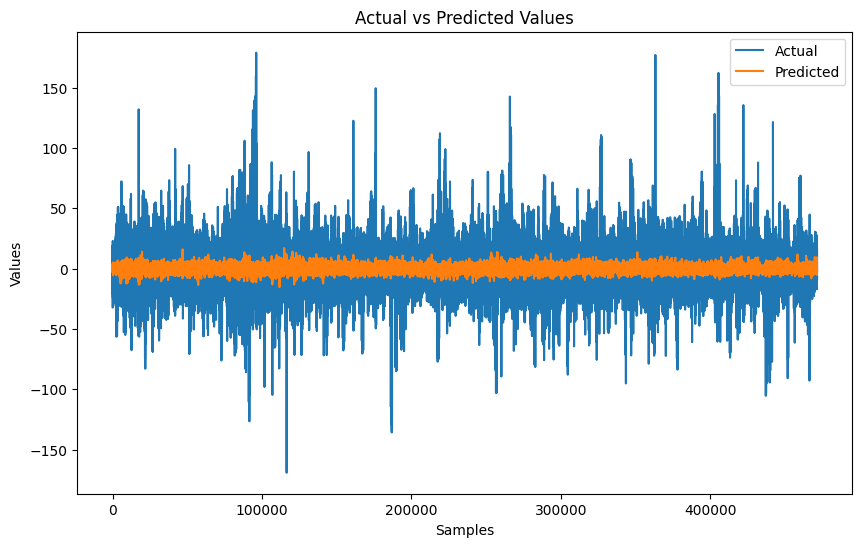

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()


In [22]:
def generate_features(cumulative_test_df, current_test, pipeline):
    transformed_df = pipeline.transform(cumulative_test_df)
    
    # Only return rows corresponding to the current test dataframe
    return transformed_df.iloc[-len(current_test):]

In [23]:
if kaggle_environment:
    import optiver2023
    env = optiver2023.make_env()
    iter_test = env.iter_test()

In [24]:
if kaggle_environment:
    # To count how many time the "for loop" runs.
    counter = 0

    # init 3 empty lists
    test_ls, revealed_targets_ls, sample_prediction_ls = [], [], []
    cumulative_test_df = pd.DataFrame()

    for (test_in, revealed_targets, sample_prediction) in iter_test:
        # Append the dataframe that API return into the list.
        test_ls.append(test_in.copy())
        revealed_targets_ls.append(revealed_targets.copy())
        sample_prediction_ls.append(sample_prediction.copy())

        cumulative_test_df = pd.concat([cumulative_test_df, test_in], axis=0, ignore_index=True)

        # Generate features
        test_transformed = generate_features(cumulative_test_df, test_in, pipeline)

        # Writes our predictions 
        sample_prediction["target"] = lgbm.predict(test_transformed)
        
        # This line submit our predictions.
        env.predict(sample_prediction)
        counter += 1

    print('\n', '=' * 50, sep="")
    print(f"counter: {counter}")

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.

counter: 165


In [25]:
y_test.var()


59.30724725515323